In [7]:
import pandas as pd

df = pd.read_csv('C:/Users/mohai/code/torontoCrimeProject/data/Major_Crime_Indicators_Open_Data.csv')

print(df.head())


              X             Y  OBJECTID EVENT_UNIQUE_ID  \
0 -8.809036e+06  5.431523e+06         1  GO-20141260264   
1 -8.814320e+06  5.435514e+06         2  GO-20141260033   
2 -8.832825e+06  5.419631e+06         3  GO-20141259834   
3 -8.847292e+06  5.429042e+06         4  GO-20141264084   
4  6.327780e-09  5.664924e-09         5  GO-20141260577   

              REPORT_DATE                OCC_DATE  REPORT_YEAR REPORT_MONTH  \
0  2014/01/01 05:00:00+00  2014/01/01 05:00:00+00         2014      January   
1  2014/01/01 05:00:00+00  2013/12/31 05:00:00+00         2014      January   
2  2014/01/01 05:00:00+00  2014/01/01 05:00:00+00         2014      January   
3  2014/01/01 05:00:00+00  2013/12/31 05:00:00+00         2014      January   
4  2014/01/01 05:00:00+00  2014/01/01 05:00:00+00         2014      January   

   REPORT_DAY  REPORT_DOY  ... UCR_CODE  UCR_EXT              OFFENCE  \
0           1           1  ...     1430      100              Assault   
1           1           

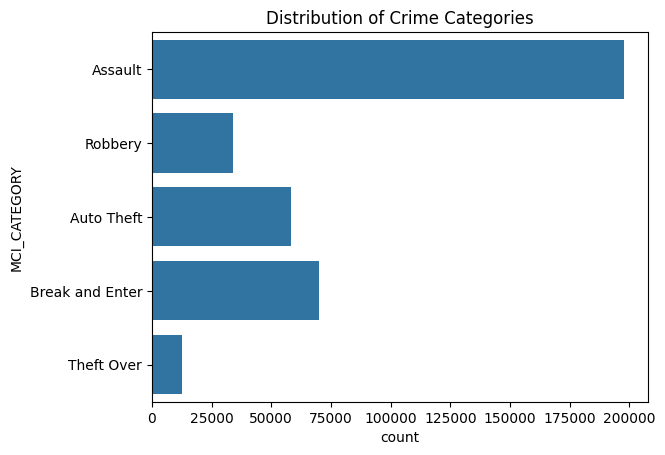

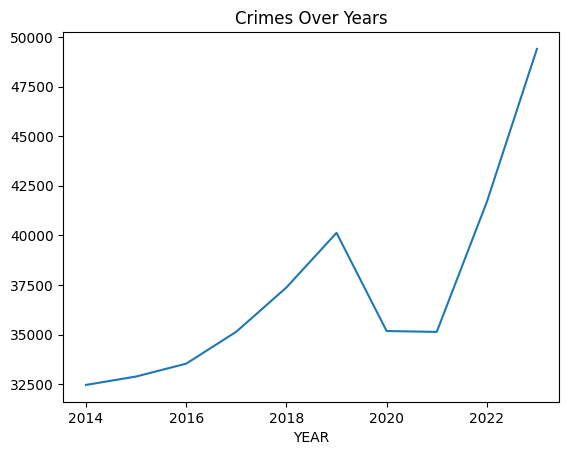

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of crimes by category
sns.countplot(y='MCI_CATEGORY', data=df)
plt.title('Distribution of Crime Categories')
plt.show()

# Time series plot for crimes over the years
df['YEAR'] = pd.DatetimeIndex(df['REPORT_DATE']).year
df.groupby('YEAR').size().plot(kind='line', title='Crimes Over Years')
plt.show()




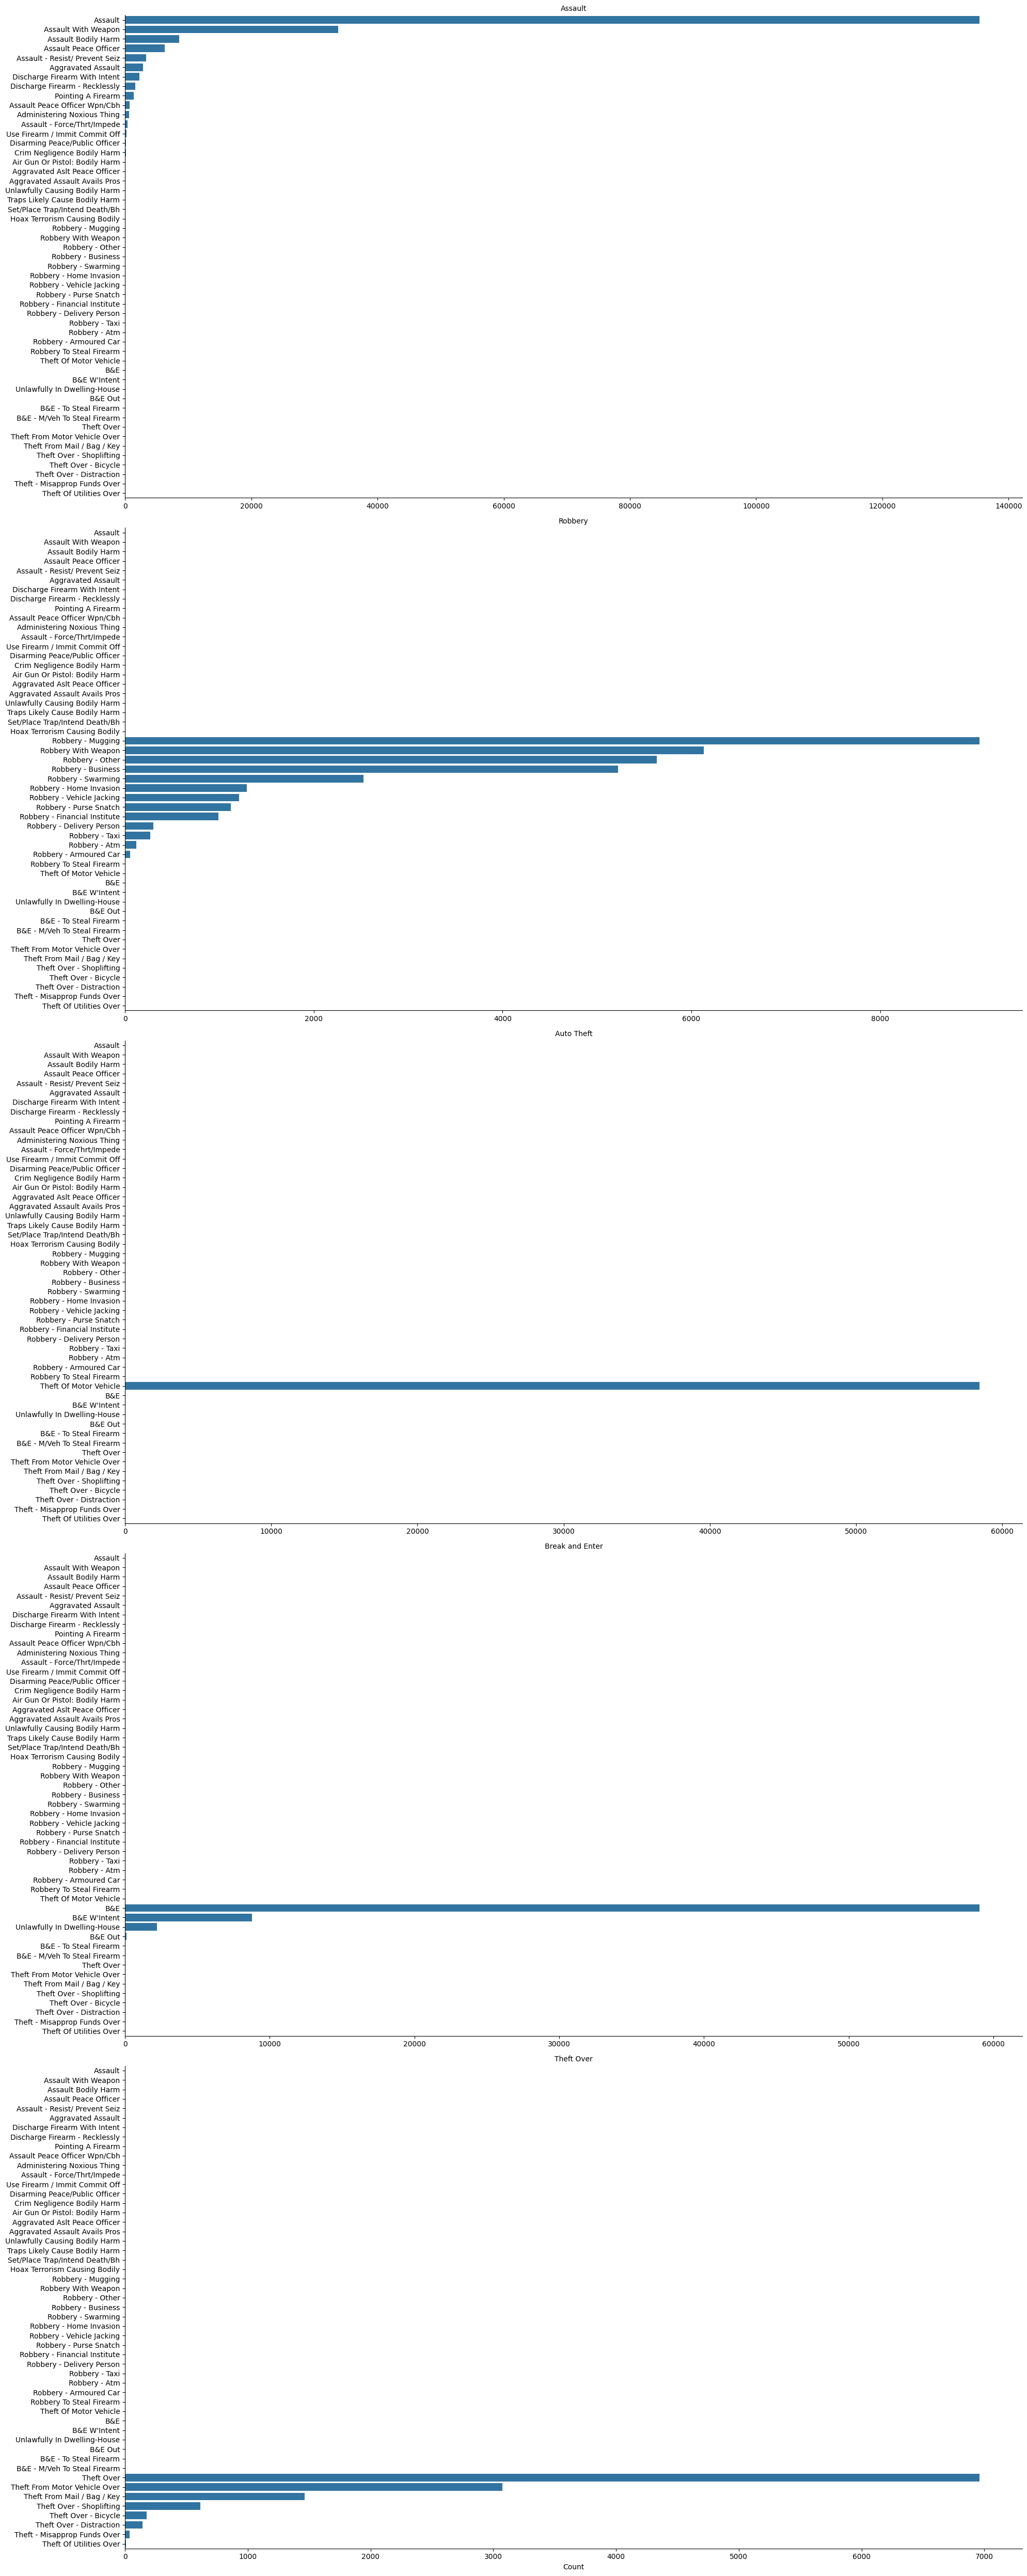

In [25]:
# Set 'height' to a larger value to increase the subplot height
g = sns.FacetGrid(df, row='MCI_CATEGORY', height=10, aspect=2, sharex=False)

# Define the plotting function
def plot_filtered_offenses(data, **kwargs):
    # Filter data for the given 'MCI_CATEGORY'
    sns.countplot(y='OFFENCE', data=data, order=data['OFFENCE'].value_counts().index, **kwargs)

# Map the DataFrame through the plotting function for each category
g.map_dataframe(plot_filtered_offenses)

# Set titles and adjust labels as necessary
g.set_titles('{row_name}')
g.set_xlabels('Count')
g.set_ylabels('')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [51]:
# Filter out rows where any of the columns contain 'NSA'
df = df[~(df == 'NSA').any(axis=1)]

# Convert REPORT_DATE and OCC_DATE to datetime objects
df['REPORT_DATE'] = pd.to_datetime(df['REPORT_DATE'])
df['OCC_DATE'] = pd.to_datetime(df['OCC_DATE'])


In [80]:
from sklearn.model_selection import train_test_split

X = df[['REPORT_HOUR', 'REPORT_YEAR', 'LAT_WGS84', 'LONG_WGS84']].copy()  # Make a copy to avoid modifying the original DataFrame
X['NEIGHBOURHOOD_140'] = df['NEIGHBOURHOOD_140']

y = df['MCI_CATEGORY']

# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd

# Assuming X and y are already defined with the relevant columns
# Perform one-hot encoding for the 'NEIGHBOURHOOD_140' column
X = pd.get_dummies(X, columns=['NEIGHBOURHOOD_140'], drop_first=True)

# Splitting dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predictions and evaluation
probabilities = model.predict_proba(X_test)
print(classification_report(y_test, predictions))


                 precision    recall  f1-score   support

        Assault       0.66      0.81      0.73     39044
     Auto Theft       0.57      0.50      0.53     11556
Break and Enter       0.45      0.34      0.38     13788
        Robbery       0.49      0.32      0.39      6622
     Theft Over       0.14      0.06      0.08      2363

       accuracy                           0.60     73373
      macro avg       0.46      0.40      0.42     73373
   weighted avg       0.58      0.60      0.58     73373



In [89]:
# Create a DataFrame to store the probabilities
neighborhood_probabilities = pd.DataFrame(probabilities, columns=model.classes_)

# Get the neighborhood columns from X_test
neighborhood_columns = [col for col in X_test.columns if col.startswith('NEIGHBOURHOOD_140')]

# Concatenate neighborhood columns and probabilities DataFrame
neighborhood_probabilities = pd.concat([X_test[neighborhood_columns], neighborhood_probabilities], axis=1)

# Calculate the mean probability for each crime category in each neighborhood
mean_probabilities_by_neighborhood = {}
for column in neighborhood_columns:
    neighborhood_name = column.split('_')[-1]
    mean_probabilities_by_neighborhood[neighborhood_name] = neighborhood_probabilities.groupby(column).mean()

# Display the mean probabilities
for neighborhood_name, mean_probabilities in mean_probabilities_by_neighborhood.items():
    print(f"Mean probabilities for neighborhood '{neighborhood_name}':")
    print(mean_probabilities)
    print()

Mean probabilities for neighborhood 'Agincourt South-Malvern West (128)':
                                                   NEIGHBOURHOOD_140_Alderwood (20)  \
NEIGHBOURHOOD_140_Agincourt South-Malvern West ...                                    
False                                                                      0.002857   
True                                                                            0.0   

                                                   NEIGHBOURHOOD_140_Annex (95)  \
NEIGHBOURHOOD_140_Agincourt South-Malvern West ...                                
False                                                                  0.015205   
True                                                                        0.0   

                                                   NEIGHBOURHOOD_140_Banbury-Don Mills (42)  \
NEIGHBOURHOOD_140_Agincourt South-Malvern West ...                                            
False                                                 

In [91]:
# Specify the path where you want to save the CSV file
csv_file_path = 'C:/Users/mohai/code/torontoCrimeProject/results/InitialBaselineResults.csv'

# Export the DataFrame to a CSV file
neighborhood_probabilities.to_csv(csv_file_path, index=False)